# Image colorization using CNN


## Libraries and hardware setup

In [ ]:
! pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import kornia
from statistics import mean

from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils

from skimage.color import rgb2lab

In [ ]:
torch.cuda.is_available()

False

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import and preprocess dataset (CIFAR10)
In this section, we import the dataset and process it properly. We discard the labels (we don't care about them since our goal is colorization, not classification) and set up a new dataset whose features are the L channel and whose labels are the AB channels. We then set up a Dataloader to process the data in batches.


In [ ]:
#Transform to LAB and separate the L and (a,b) channels
class RGB_to_LAB:
  def __call__(self, sample):
    tensor = kornia.color.rgb_to_lab(sample) # 3 x 32 x 32
    l = tensor[0, : , :]
    bw = torch.empty([3, 32, 32])
    bw[0, : , :] = l
    bw[1, : , :] = l
    bw[2, : , :] = l
    return bw, tensor[1:, :, :]

#Function to switch back to rgb
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

transform_rgb_lab = RGB_to_LAB()
composed = transforms.Compose([transforms.ToTensor(), transform_rgb_lab])

In [ ]:
#Load dataset --> set download = True if it's the first time you're opening it
dataset = CIFAR10(root = "/content/gdrive/My Drive/CIFAR10", download = False,
                  transform = composed, train = True)


In [ ]:
#Remove labels from dataset
def discard_labels(data):
  return([datum[0] for datum in data])

dataset = discard_labels(dataset)

In [ ]:
#Separate the l and ab channels and store them as tensor

# dato = (l, ab)
def select_l(data):
  return([datum[0] for datum in data])
def select_ab(data):
  return([datum[1] for datum in data])

dataset_l =  select_l(dataset)
dataset_ab = select_ab(dataset)

#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_ab = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_ab])

#Set up new dataset
N_images = 40000
train = data_utils.TensorDataset(dataset_l[: N_images], dataset_ab[: N_images])
test = data_utils.TensorDataset(dataset_l[N_images:], dataset_ab[N_images: ])


In [ ]:
#Data loader
batch_size = 200
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

## Define CNN architecture

In [ ]:
class network_model_L2(nn.Module):
  def __init__(self):
    super(network_model_L2, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6]) #first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():
      param.requires_grad = False

    # define our layers on top of resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )


  def forward(self, input):
    y = self.resnet_base(input)                                                 # first go through resnet
    z = self.cnn_next(y)                                                        # then go through our layers
    return z

## Training (MSE loss)

In [ ]:
network = network_model_L2()                                                    # CNN
loss = nn.MSELoss()                                                             # We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-4, weight_decay=0.0)       # Adam optimizer.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


In [ ]:
losses_train = []
losses_val = []

epochs = 100
patience = 10
min_val = 0

PATH = "L2_3232_model_trained_horizontalflip.pt"

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train() #Set it up for training
    i = 0
    ls = []
    for features, labels in train_loader:
      transformed_batch = torch.stack([transform(img) for img in features])

      features = transformed_batch
      features = features.to(device)
      labels = labels.to(device)
      network = network.to(device)

      predictions = network(features)


      L = loss(predictions, labels.type(torch.float32))
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%50 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1

    losses_train.append(mean(ls))


#########################################################################################

    # Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        network = network.to(device)

        prediction_val = network(features)

        val_loss = loss(prediction_val, labels.type(torch.float32))
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      print("The minimum was:", min_val)
      losses_val.append(mean(val_batches))


    # Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)
      torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': min_val,
            }, PATH)

    # Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

Epoch  0
Loss at iteration  0  is  196.6347198486328
Loss at iteration  50  is  192.06015014648438
Loss at iteration  100  is  164.9784393310547
Loss at iteration  150  is  157.01361083984375
At epoch  0  validation loss  165.82631744384764
The minimum was: 0
Epoch  1
Loss at iteration  0  is  174.69390869140625
Loss at iteration  50  is  181.73793029785156
Loss at iteration  100  is  149.0964813232422
Loss at iteration  150  is  138.08306884765625
At epoch  1  validation loss  158.13042449951172
The minimum was: 0
Epoch  2
Loss at iteration  0  is  157.4213104248047
Loss at iteration  50  is  173.62635803222656
Loss at iteration  100  is  159.9145050048828
Loss at iteration  150  is  164.1654815673828
At epoch  2  validation loss  153.88952270507812
The minimum was: 158.13042449951172
Epoch  3
Loss at iteration  0  is  157.0093231201172
Loss at iteration  50  is  138.7145538330078
Loss at iteration  100  is  133.0594482421875
Loss at iteration  150  is  156.4340057373047
At epoch  3  

Text(0.5, 0, 'Epoch')

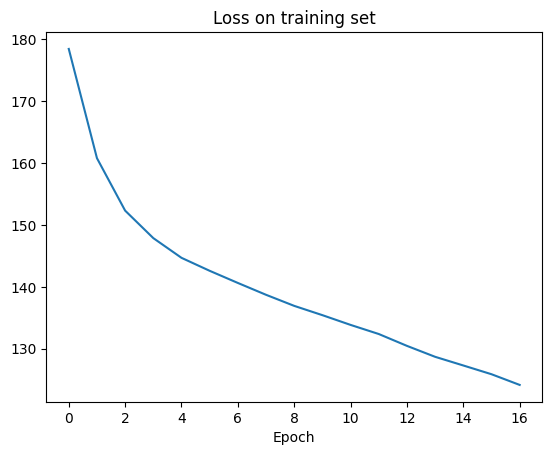

In [ ]:
plt.plot(losses_train)
plt.title("Loss on training set")
plt.xlabel("Epoch")

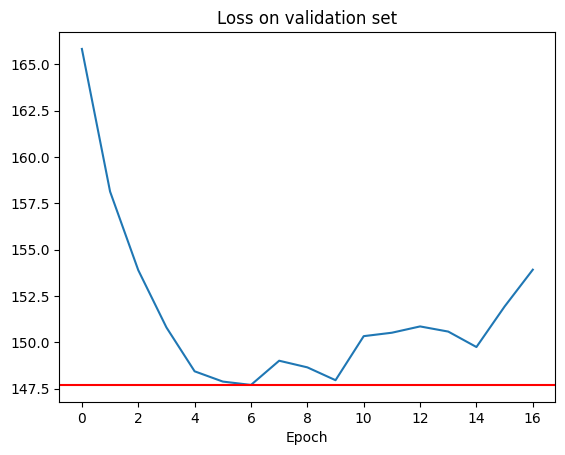

In [ ]:
plt.plot(losses_val)
plt.title("Loss on validation set")
plt.xlabel("Epoch")
plt.axhline(y=min_val, color='r', linestyle='-')

## Load weights

In [ ]:
network = network_model_L2()
data = torch.load('/content/gdrive/MyDrive/Vision/Progetto/FINALE_32/L2_3232_model_trained_horizontalflip.pt', map_location=torch.device('cpu'))

network.load_state_dict(data['model_state_dict'])

network.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.5MB/s]


network_model_L2(
  (resnet_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Print test output images

In [ ]:
for index in range(100):

  rgb = LAB_to_RGB(test[index][0][0], test[index][1])

  with torch.no_grad():
    predicted_ab = network(torch.unsqueeze(test[index][0], 0))
    rgb_pred = LAB_to_RGB(test[index][0][0], torch.squeeze(predicted_ab, 0))

  bw = torch.permute(test[index][0], [1,2,0]).clone()
  bw -= bw.min(1, keepdim=True)[0]
  bw /= bw.max(1, keepdim=True)[0]

  print('\n', '\n')

  fig, ax = plt.subplots(1, 3, figsize = (10, 3.5))
  fig.suptitle("Training set", fontsize = 14)

  ax[0].imshow(bw)
  ax[0].set_title("Black and white")
  ax[0].axis("off")

  ax[1].imshow(torch.permute(rgb, [1,2,0]))
  ax[1].set_title("Original")
  ax[1].axis("off")

  ax[2].imshow(torch.permute(rgb_pred, [1,2,0]))
  ax[2].set_title("Colorized")
  ax[2].axis("off")

  plt.show()

Output hidden; open in https://colab.research.google.com to view.